# Import required libraries

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from experiments.CarOnHill.plot_utils import plot_on_grid, plot_value
from slimRL.sample_collection.utils import load_replay_buffer_store
from experiments.CarOnHill.optimal import NX, NV
BASE_PATH = "logs/"

# Hyperparameter setting for generating the plots

In [2]:
# Set these value before running the cells below
experiments_to_run = ['test/FQI']
# Set these value to True if you want to generate these plots
SAMPLES_DISTRIBUTION = True
TD_ERROR_ON_RB_DATA = True
TD_ERROR_ON_GRID = True
DIFF_FROM_OPT_Q = True
DIFF_FROM_OPT_V = True
PERFORMANCE_LOSS_Q = True
PERFORMANCE_LOSS_V= True
BELLMAN_ITERATIONS_FOR_POLICY = [5, 10, 15, 20, 25, 29]
BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS = [5, 10, 15, 20, 25, 29]
if DIFF_FROM_OPT_Q or PERFORMANCE_LOSS_Q:
    OPT_Q = np.load(os.path.join(BASE_PATH, "Q*.npy"))
if DIFF_FROM_OPT_V or PERFORMANCE_LOSS_V:
    OPT_V = np.load(os.path.join(BASE_PATH, "V*.npy"))

# Check and load all the relevant metrics for plotting

In [3]:
experiment_seed_folder_map = {experiment: [seed_run
            for seed_run in os.listdir(os.path.join(BASE_PATH, experiment))
            if not os.path.isfile(os.path.join(BASE_PATH,experiment, seed_run))] for experiment in experiments_to_run}
assert all([os.path.exists(os.path.join(BASE_PATH, experiment_folder_path)) for experiment_folder_path in experiment_seed_folder_map]), "Found experiments with no corresponing folders"
metrics = {}
for experiment in experiment_seed_folder_map:
    metrics[experiment] = {}
    if SAMPLES_DISTRIBUTION:
        metrics[experiment].setdefault("samples_distribution",  np.load(os.path.join(BASE_PATH, experiment, "samples_stats.npy"))) 
        metrics[experiment].setdefault("rewards_distribution", np.load(os.path.join(BASE_PATH, experiment, "rewards_stats.npy")))
    if TD_ERROR_ON_GRID or DIFF_FROM_OPT_Q or DIFF_FROM_OPT_V or PERFORMANCE_LOSS_Q or PERFORMANCE_LOSS_V or len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS)>0:
        metrics[experiment].setdefault("samples_distribution",  np.load(os.path.join(BASE_PATH, experiment, "samples_stats.npy")))
        metrics[experiment].setdefault("scaling",  metrics[experiment]["samples_distribution"]/metrics[experiment]["samples_distribution"].sum())
    if TD_ERROR_ON_RB_DATA:
        metrics[experiment].setdefault("T_q_rb", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "T_q_rb.npy")) for seed_run in experiment_seed_folder_map[experiment]})
        metrics[experiment].setdefault("q_i_rb", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_rb.npy")) for seed_run in experiment_seed_folder_map[experiment]})
        metrics[experiment].setdefault("rb_store", load_replay_buffer_store(os.path.join(BASE_PATH, experiment, "replay_buffer.json")))
    if TD_ERROR_ON_GRID:
        metrics[experiment].setdefault("T_q_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "T_q_grid.npy")) for seed_run in experiment_seed_folder_map[experiment]})
        metrics[experiment].setdefault("q_i_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_grid.npy")) for seed_run in experiment_seed_folder_map[experiment]})
    if DIFF_FROM_OPT_Q or DIFF_FROM_OPT_V:
        metrics[experiment].setdefault("q_i_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_rb.npy")) for seed_run in experiment_seed_folder_map[experiment]})
    if PERFORMANCE_LOSS_Q or PERFORMANCE_LOSS_V:
        metrics[experiment].setdefault("q_pi_i", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_pi_i.npy")) for seed_run in experiment_seed_folder_map[experiment]})
        if PERFORMANCE_LOSS_V:
            metrics[experiment].setdefault("q_i_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_grid.npy")) for seed_run in experiment_seed_folder_map[experiment]})
    if len(BELLMAN_ITERATIONS_FOR_POLICY) > 0:
        metrics[experiment].setdefault(f"q_i_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_grid.npy")) for seed_run in experiment_seed_folder_map[experiment]})
    if len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS):
        metrics[experiment].setdefault("q_pi_i", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_pi_i.npy")) for seed_run in experiment_seed_folder_map[experiment]})
        metrics[experiment].setdefault("q_i_grid", {seed_run: np.load(os.path.join(BASE_PATH, experiment, seed_run, "q_i_grid.npy")) for seed_run in experiment_seed_folder_map[experiment]})

## Plot samples distribution 
Run this cell only if `PLOT_SAMPLES_DISTRIBUTION=True`

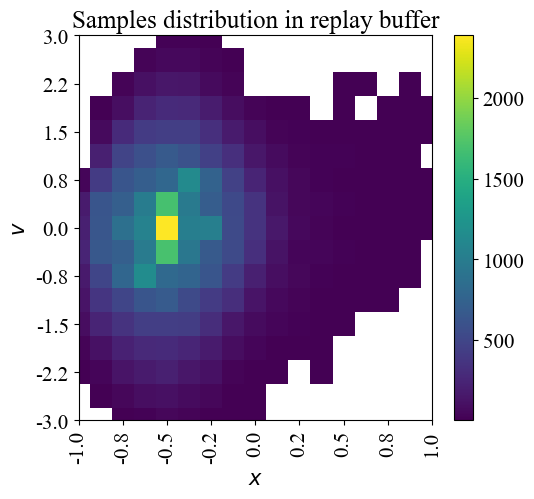

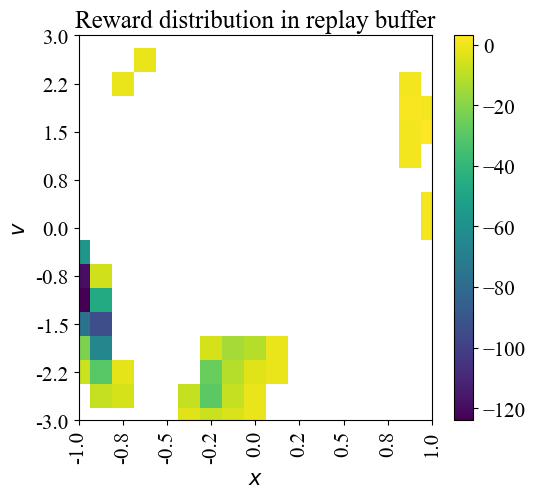

In [4]:
for experiment in experiment_seed_folder_map:
    plot_on_grid(values=metrics[experiment]["samples_distribution"], zeros_to_nan=True, title=f"Samples distribution in replay buffer").savefig(os.path.join(BASE_PATH, experiment, "samples_distribution.pdf"))
    plot_on_grid(values=metrics[experiment]["rewards_distribution"], zeros_to_nan=True, title="Reward distribution in replay buffer").savefig(os.path.join(BASE_PATH, experiment, "rewards_distribution.pdf"))

## Plot $\Vert \Gamma Q_{i-1} - Q_i\Vert_2$ on replay buffer data
Run this cell only if `PLOT_TD_ERROR_ON_RB_DATA=True`

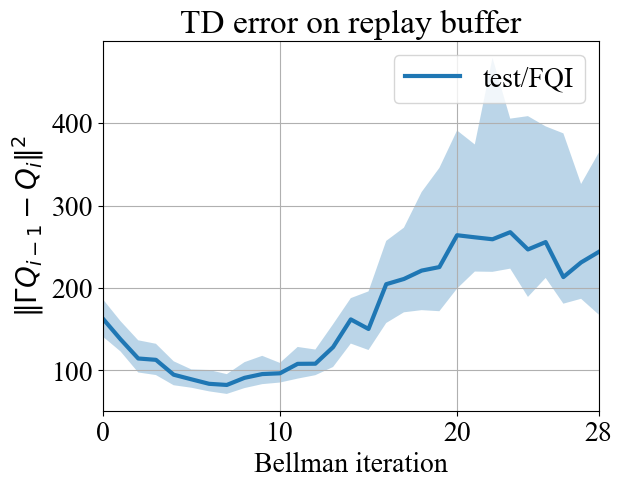

In [5]:
td_error_on_rb = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_i_rb"])
    n_bellman_iterations = list(metrics[experiment]["q_i_rb"].values())[0].shape[0]
    td_error_on_rb[experiment] = np.zeros((n_seeds, n_bellman_iterations-1))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        td_error_on_rb[experiment][idx_seed] = np.linalg.norm(
                        metrics[experiment]["T_q_rb"][seed_run]
                        - metrics[experiment]["q_i_rb"][seed_run][1:][np.arange(n_bellman_iterations-1)[:, None],np.arange(len(metrics[experiment]["rb_store"]["action"])), metrics[experiment]["rb_store"]["action"]]
                    , axis=1)**2
plot_value("Bellman iteration", "$\Vert \Gamma Q_{i-1} - Q_i\Vert^2$", np.arange(0, n_bellman_iterations-1).tolist(), td_error_on_rb, ticksize=10, title="TD error on replay buffer", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "td_error_rb_data.pdf"))

## Plot $\Vert\Gamma Q_{i-1} - Q_i\Vert_2$ on grid
Run this cell only if `PLOT_TD_ERROR_ON_GRID=True`

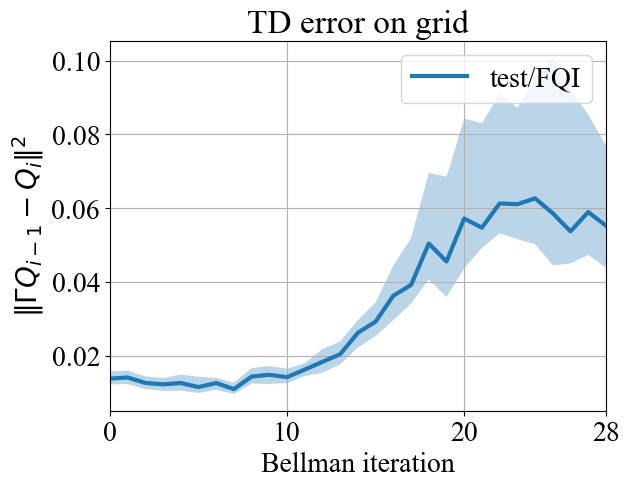

In [6]:
td_error_on_grid = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_i_grid"])
    n_bellman_iterations = list(metrics[experiment]["q_i_grid"].values())[0].shape[0]
    td_error_on_grid[experiment] = np.zeros((n_seeds, n_bellman_iterations-1))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        td_error_on_grid[experiment][idx_seed] = np.sum(np.square(metrics[experiment]["T_q_grid"][seed_run] - metrics[experiment]["q_i_grid"][seed_run][1:]) *
                               metrics[experiment]["scaling"].reshape(-1)[:,np.newaxis], axis=(1,2))
                    
plot_value("Bellman iteration", "$\Vert \Gamma Q_{i-1} - Q_i\Vert^2$", np.arange(0, n_bellman_iterations-1).tolist(), td_error_on_grid, ticksize=10, title="TD error on grid", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "td_error_grid.pdf"))

## Plot $\Vert Q^{*} - Q_i\Vert_2$
Run this cell only if `PLOT_DIFF_FROM_OPT_Q=True`

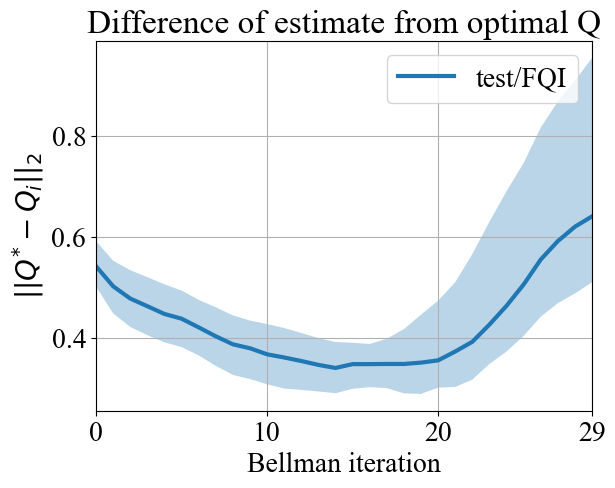

In [7]:
q_opt_diff = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_i_grid"])
    n_bellman_iterations = list(metrics[experiment]["q_i_grid"].values())[0].shape[0]
    q_opt_diff[experiment] = np.zeros((n_seeds, n_bellman_iterations))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        q_opt_diff[experiment][idx_seed] = np.sqrt(
                        np.sum(np.square(OPT_Q.reshape(-1,2) - metrics[experiment]["q_i_grid"][seed_run]) *
                               metrics[experiment]["scaling"].reshape(-1)[:,np.newaxis], axis=(1,2)))
plot_value("Bellman iteration", "$||Q^{*} - Q_i||_2$", np.arange(0, n_bellman_iterations).tolist(), q_opt_diff, ticksize=10, title="Difference of estimate from optimal Q", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "q_i_opt_diff.pdf"))

## Plot $\Vert V^{*} - V_i\Vert_2$
Run this cell only if `PLOT_DIFF_FROM_OPT_V=True`

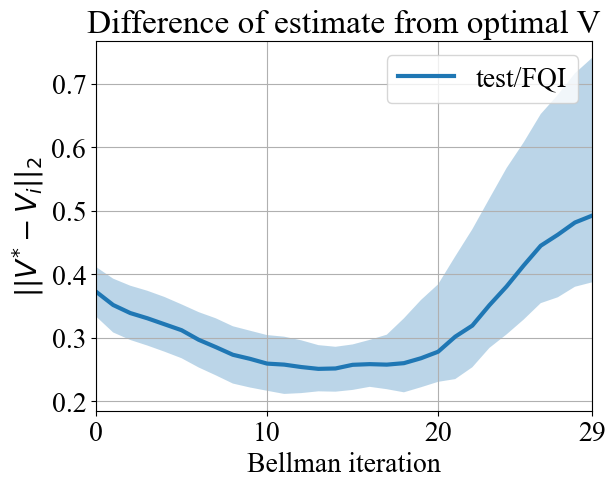

In [8]:
v_opt_diff = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_i_grid"])
    n_bellman_iterations = list(metrics[experiment]["q_i_grid"].values())[0].shape[0]
    v_opt_diff[experiment] = np.zeros((n_seeds, n_bellman_iterations))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        v_i = np.max(metrics[experiment]["q_i_grid"][seed_run], axis=-1)
        v_opt_diff[experiment][idx_seed] = np.sqrt(
                        np.sum(np.square(v_i - OPT_V.reshape(-1)) *
                               metrics[experiment]["scaling"].reshape(-1), axis=1))
plot_value("Bellman iteration", "$||V^{*} - V_i||_2$", np.arange(0, n_bellman_iterations).tolist(), v_opt_diff, ticksize=10, title="Difference of estimate from optimal V", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "v_i_opt_diff.pdf"))

## Plot $\Vert Q^{*} - Q^{\pi_i}\Vert_2$
Run this cell only if `PLOT_PERFORMANCE_LOSS_Q=True`

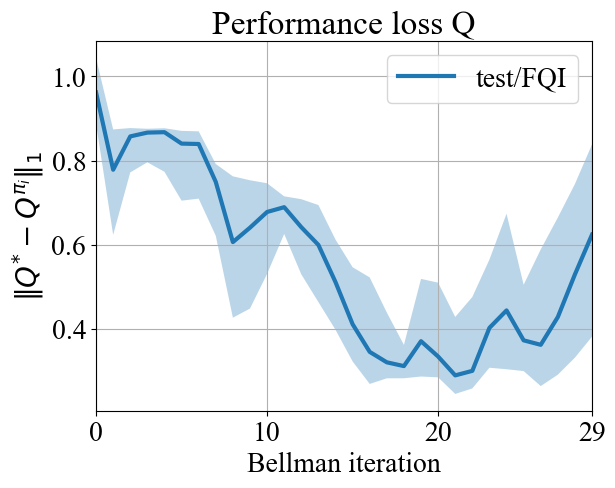

In [9]:
q_perf_loss = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_pi_i"])
    n_bellman_iterations = list(metrics[experiment]["q_pi_i"].values())[0].shape[0]
    q_perf_loss[experiment] = np.zeros((n_seeds, n_bellman_iterations))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        q_perf_loss[experiment][idx_seed] = np.sqrt(
                        np.sum(np.abs(OPT_Q.reshape(-1,2) - metrics[experiment]["q_pi_i"][seed_run]) *
                               metrics[experiment]["scaling"].reshape(-1)[:,np.newaxis], axis=(1,2)))
plot_value("Bellman iteration", "$\Vert Q^{*} - Q^{\pi_i}\Vert_1$", np.arange(0, n_bellman_iterations).tolist(), q_perf_loss, ticksize=10, title="Performance loss Q", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "performance_loss_q.pdf"))

## Plot $\Vert V^{*} - V^{\pi_i}\Vert_2$
Run this cell only if `PLOT_PERFORMANCE_LOSS_V=True`

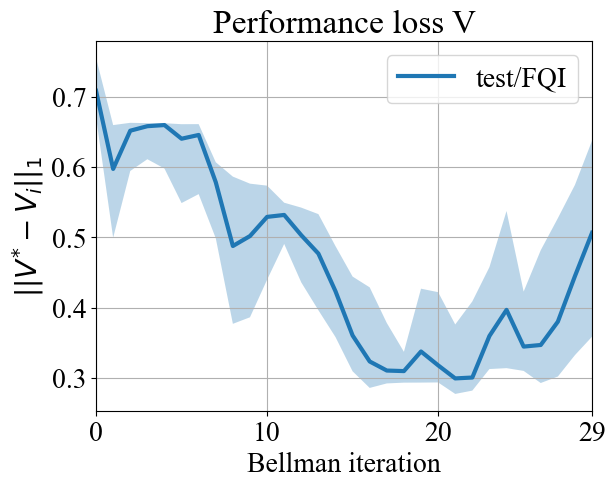

In [10]:
v_perf_loss = {}
for experiment in experiment_seed_folder_map:
    n_seeds = len(metrics[experiment]["q_pi_i"])
    n_bellman_iterations = list(metrics[experiment]["q_pi_i"].values())[0].shape[0]
    v_perf_loss[experiment] = np.zeros((n_seeds, n_bellman_iterations))
    for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
        v_pi_i = metrics[experiment]["q_pi_i"][seed_run][np.arange(n_bellman_iterations)[:, None],np.arange(NX*NV), np.argmax(metrics[experiment]["q_i_grid"], axis=-1)]
        v_perf_loss[experiment][idx_seed] = np.sqrt(
                        np.sum(np.abs(v_pi_i - OPT_V.reshape(-1)) *
                               metrics[experiment]["scaling"].reshape(-1), axis=1))
plot_value("Bellman iteration", "$||V^{*} - V_i||_1$", np.arange(0, n_bellman_iterations).tolist(), v_perf_loss, ticksize=10, title="Performance loss V", fontsize=20, linewidth=3).savefig(os.path.join(BASE_PATH, experiments_to_run[0], "performance_loss_v.pdf"))

## Plot policy $\pi_i(s)$
Run this cell only if `BELLMAN_ITERATIONS_FOR_POLICY_PLOT`$\neq$`[]`

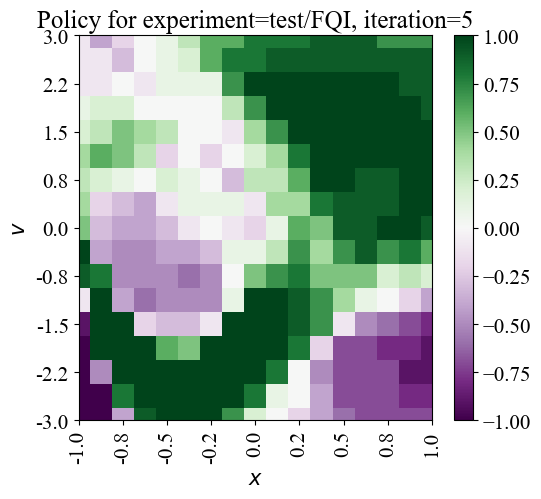

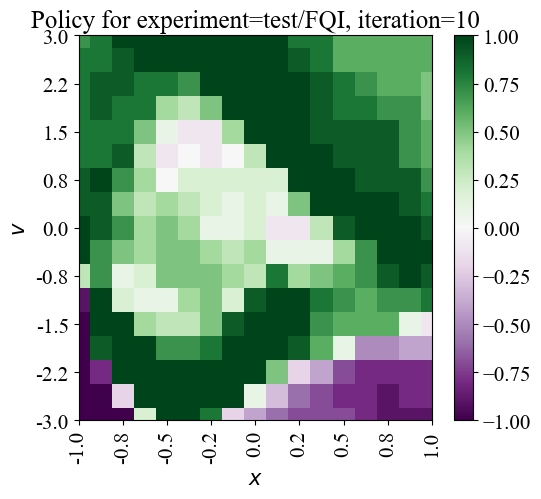

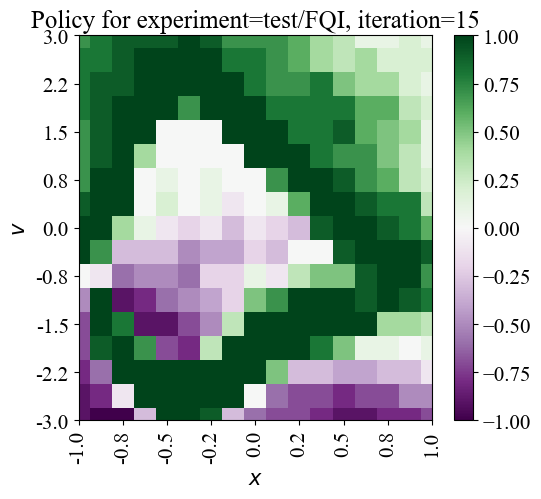

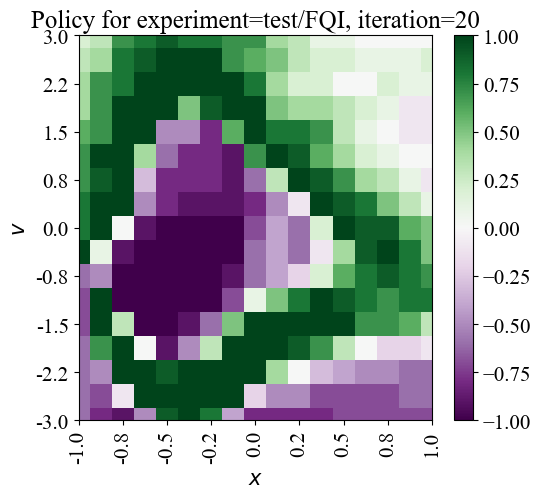

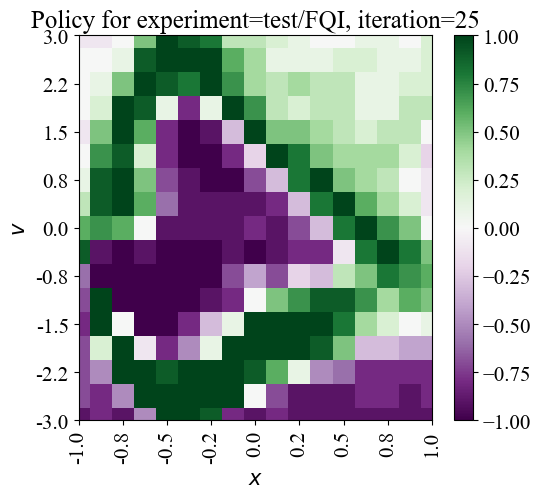

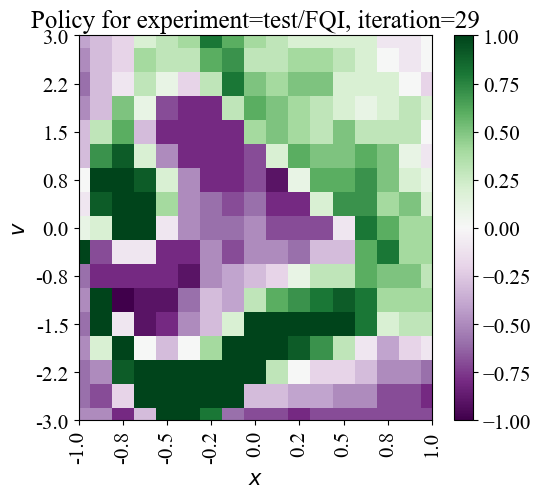

In [11]:
for iteration in BELLMAN_ITERATIONS_FOR_POLICY:
    for experiment in experiment_seed_folder_map:
        n_seeds = len(metrics[experiment]["q_i_grid"])
        policy = np.zeros((n_seeds, NX*NV))
        for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
            policy[idx_seed] = (metrics[experiment]["q_i_grid"][seed_run][iteration][:, 1] >metrics[experiment]["q_i_grid"][seed_run][iteration][:, 0]).astype(float)
        policy= np.mean(policy, axis=0)
        policy = 2 * (policy - np.min(policy)) / (np.max(policy) - np.min(policy)) - 1
        policy = policy.reshape(NX, NV)
        plot_on_grid(policy, cmap="PRGn", title=f"Policy for experiment={experiment}, iteration={iteration}").savefig(os.path.join(BASE_PATH, experiment, f"policy_iter={iteration}.pdf"))
        

## Plot $V^{*} - V^{\pi_i}$ on grid
Run this cell only if `BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS`$\neq$`[]`

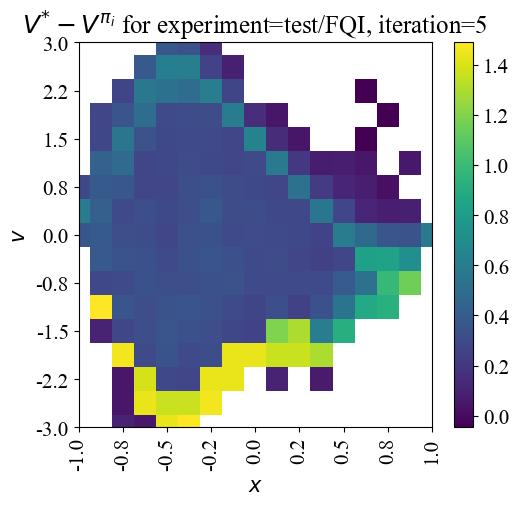

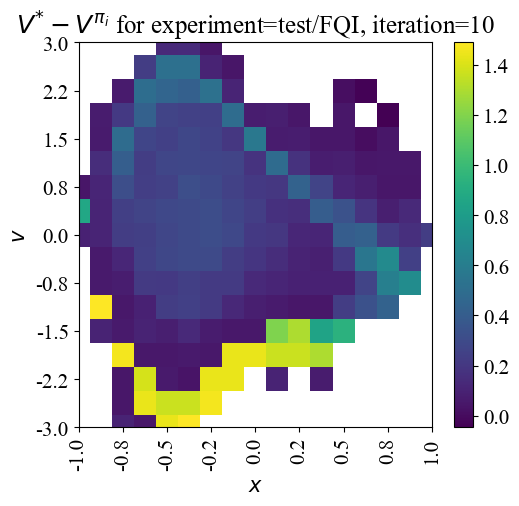

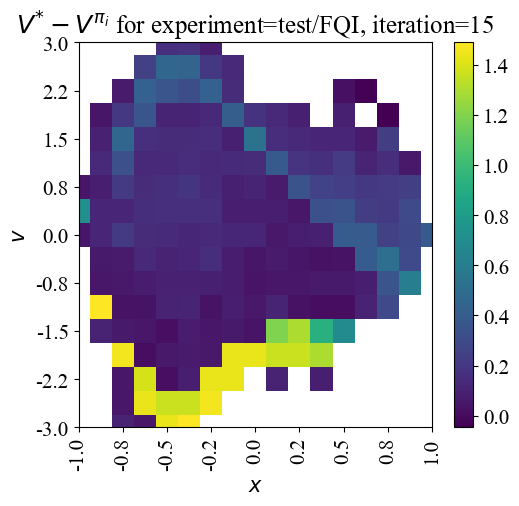

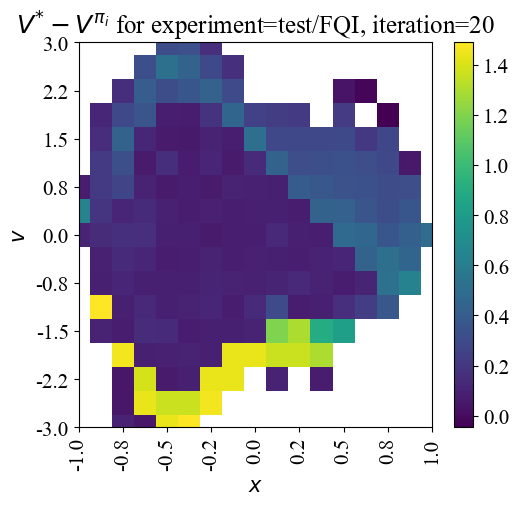

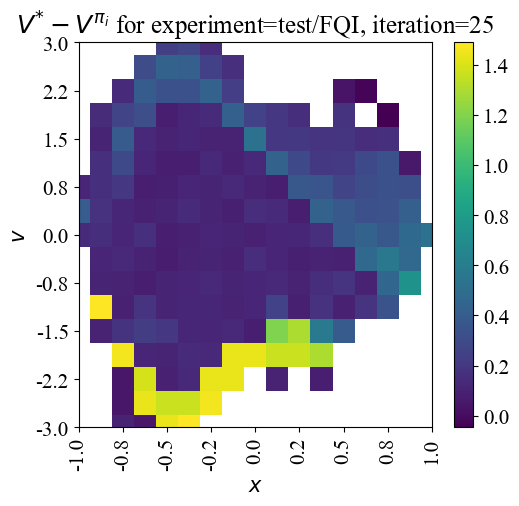

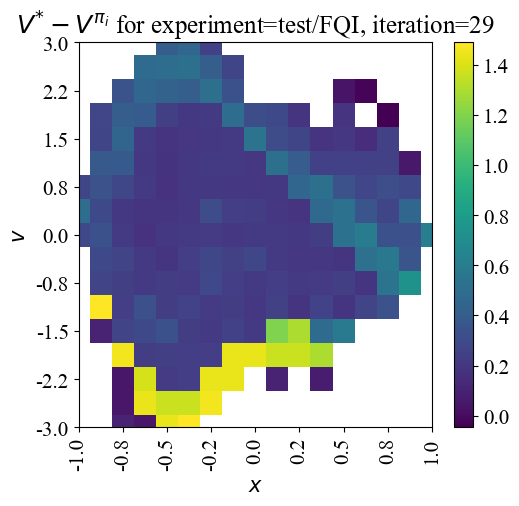

In [12]:
for iteration in BELLMAN_ITERATIONS_FOR_POLICY:
    for experiment in experiment_seed_folder_map:
        n_seeds = len(metrics[experiment]["q_i_grid"])
        v_perf = np.zeros((n_seeds, NX*NV))
        for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
            v_pi_i = metrics[experiment]["q_pi_i"][seed_run][np.arange(n_bellman_iterations)[:, None],np.arange(NX*NV), np.argmax(metrics[experiment]["q_i_grid"], axis=-1)][iteration]
            v_perf[idx_seed] = OPT_V.reshape(-1) - v_pi_i
        v_perf= np.mean(v_perf, axis=0)
        v_perf = v_perf.reshape(NX, NV)
        v_perf = v_perf * (metrics[experiment]["scaling"] > 0).astype(float)
        plot_on_grid(v_perf, True, title="$V^{*} - V^{\pi_{i}}$"+f" for experiment={experiment}, iteration={iteration}").savefig(os.path.join(BASE_PATH, experiment, f"perf_loss_iter={iteration}.pdf"))